In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import galactic_wavelets as gw
import torch

In [2]:
nb_sims = 20

quijote_dir = '/mnt/ceph/users/fvillaescusa/Quijote/3D_cubes/'
test_dfs = []
for i in range(nb_sims):
    test_dfs.append(quijote_dir+f'fiducial/{i}/df_m_128_CIC_z=0.npy')
dx = 1000.0/128.0 # Mpc/h
kmax = np.pi/dx

device = 0

In [3]:
dfs = []
for i in range(nb_sims):
    dfs.append(torch.from_numpy(np.load(os.path.join(quijote_dir, test_dfs[i]))))
dfs = torch.stack(dfs).to(device)
df_shape = dfs[0].shape
N = df_shape[0]

In [4]:
J = 4
Q = 1
kc = np.pi # Cutoff frequency of the mother wavelet (in units of 2pi px^-1)
moments = [1/2, 1, 2]
erosion_threshold = 0.1

In [5]:
wst_op_full = gw.ScatteringOp(df_shape, J, Q,
                              moments=moments,
                              kc=kc,
                              device=device)
wst_op_half = gw.ScatteringOp(tuple([x//2 for x in df_shape]), J, Q,
                              moments=moments,
                              kc=kc,
                              erosion_threshold=erosion_threshold,
                              device=device)

Computing wavelets...


Done!
Computing wavelets...
Done!
Computing masks for the wavelet transform...
Done!


In [6]:
fw = torch.fft.fftshift(wst_op_full.wt_op.get_wavelets("fourier").squeeze(), dim=(-3, -2, -1))
w = torch.fft.fftshift(wst_op_full.wt_op.get_wavelets("physical").squeeze(), dim=(-3, -2, -1))

w_renorm = w.clone()
for j in range(J):
    for q in range(Q):
        w_renorm[j*Q + q] *= 2**(3*(j*Q + q)/Q)
aw_renorm = torch.absolute(w_renorm)
w_max = torch.amax(aw_renorm, dim=(-3, -2, -1), keepdim=True)
w_supports = aw_renorm > erosion_threshold*w_max

physical_units = True
if physical_units:
    sampling_step = np.pi/kmax
    xvals = np.arange(-N//2, N//2)*sampling_step
    kvals = np.fft.fftshift(2*np.pi*np.fft.fftfreq(N, sampling_step))
else:
    sampling_step = 1.0
    xvals = np.arange(-N//2, N//2)*sampling_step
    kvals = np.fft.fftshift(2*np.pi*np.fft.fftfreq(N, sampling_step))

/mnt/sw/nix/store/mpgyydv1wg7wwirp67ds6f2psq63s2p1-python-3.8.16-view/lib/python3.8/site-packages/torch/_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/tmp/ipykernel_136830/3231133691.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


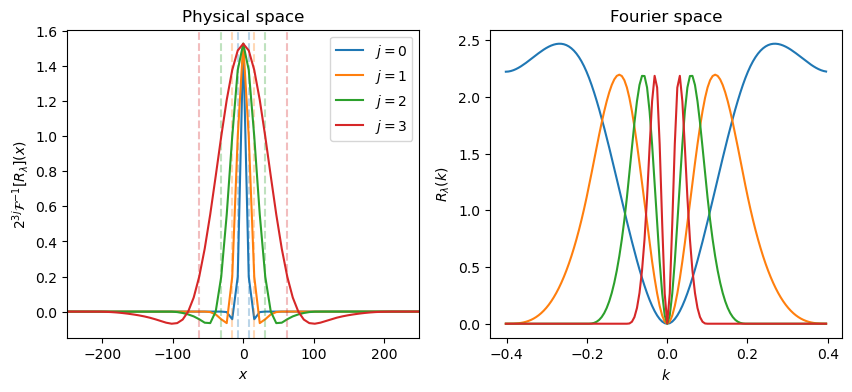

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for j in range(J):
    for q in range(Q):
        support = torch.argwhere(w_supports[j*Q + q, N//2, N//2, :])
        support_min = -(N/2 - torch.min(support[support[:, 0] < N/2]))
        support_max = torch.max(support[support[:, 0] >= N/2]) - N/2
        p = axs[0].plot(xvals, w_renorm[j*Q + q, N//2, N//2, :].cpu(), label=f"$j={j} + {q}/2$" if q != 0 else f"$j={j}$")
        axs[0].axvline(support_min.cpu()*sampling_step, linestyle="dashed", alpha=0.3, color=p[0].get_color())
        axs[0].axvline(support_max.cpu()*sampling_step, linestyle="dashed", alpha=0.3, color=p[0].get_color())

        axs[1].plot(kvals, fw[j*Q + q, N//2, N//2, :].cpu())

axs[0].legend()
axs[0].set_xlim(-N//4 * sampling_step, N//4 * sampling_step)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel(r"$2^{3j}\mathcal{F}^{-1}[R_\lambda](x)$")
axs[0].set_title("Physical space")

axs[1].set_xlabel("$k$")
axs[1].set_ylabel("$R_\lambda(k)$")
axs[1].set_title("Fourier space")

fig.show()

In [8]:
s0_full, s1_full = wst_op_full(dfs[0])
s0_halfs, s1_halfs = [], []
for i in range(8):
    k, l, m = i // 4, (i % 4) // 2, i % 2
    df_half = dfs[0][k*df_shape[0]//2:(k+1)*df_shape[0]//2,
                 l*df_shape[1]//2:(l+1)*df_shape[1]//2,
                 m*df_shape[2]//2:(m+1)*df_shape[2]//2]
    s0_half, s1_half = wst_op_half(df_half)
    s0_halfs.append(s0_half)
    s1_halfs.append(s1_half)
s0_halfs, s1_halfs = torch.stack(s0_halfs), torch.stack(s1_halfs)

Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!


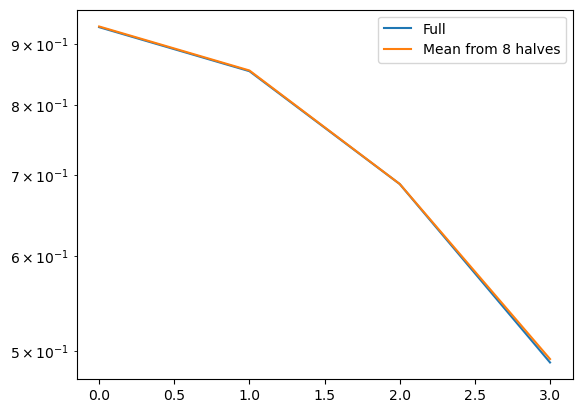

In [9]:
plt.figure()
plt.plot(s1_full[0].cpu(), label='Full')
plt.plot(s1_halfs.mean(axis=0)[0].cpu(), label='Mean from 8 halves')
plt.legend()
plt.yscale('log')
plt.show()

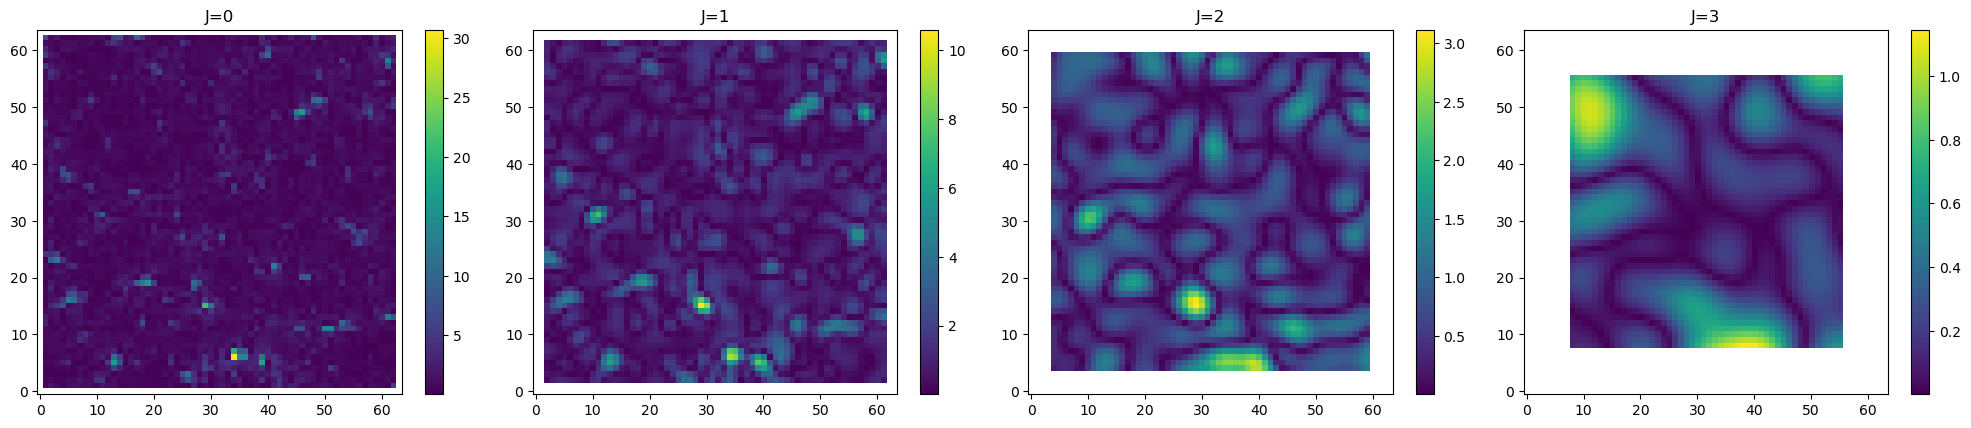

In [10]:
# Visualization of the wavelet masks
masked_awt = wst_op_half.wt_op(dfs[0][:df_shape[0]//2, :df_shape[1]//2, :df_shape[2]//2])
fig, axs = plt.subplots(1, J, figsize=(5*J, 4))
for j in range(J):
    im = axs[j].imshow(torch.abs(masked_awt).squeeze()[j, : ,: ,df_shape[2]//4].cpu(), origin='lower')
    axs[j].set_title('J=%d' %j)
    fig.colorbar(im, ax=axs[j])
fig.tight_layout()
plt.show()

In [11]:
s0_full_list, s1_full_list = [], []
s0_halfs_list, s1_halfs_list = [], []
for j in range(nb_sims):
    s0_full, s1_full = wst_op_full(dfs[j])
    s0_full_list.append(s0_full)
    s1_full_list.append(s1_full)
    s0_halfs, s1_halfs = [], []
    for i in range(8):
        k, l, m = i // 4, (i % 4) // 2, i % 2
        df_half = dfs[j, k*df_shape[0]//2:(k+1)*df_shape[0]//2,
                    l*df_shape[1]//2:(l+1)*df_shape[1]//2,
                    m*df_shape[2]//2:(m+1)*df_shape[2]//2]
        s0_half, s1_half = wst_op_half(df_half)
        s0_halfs.append(s0_half)
        s1_halfs.append(s1_half)
    s0_halfs, s1_halfs = torch.stack(s0_halfs), torch.stack(s1_halfs)
    s0_halfs_list.append(s0_halfs)
    s1_halfs_list.append(s1_halfs)
s0_full_list, s1_full_list = torch.stack(s0_full_list), torch.stack(s1_full_list)
s0_halfs_list, s1_halfs_list = torch.stack(s0_halfs_list), torch.stack(s1_halfs_list)

Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computin

In [12]:
s0_full_list.shape, s1_full_list.shape, s0_halfs_list.shape, s1_halfs_list.shape

(torch.Size([20, 3]),
 torch.Size([20, 3, 4, 1]),
 torch.Size([20, 8, 3]),
 torch.Size([20, 8, 3, 4, 1]))

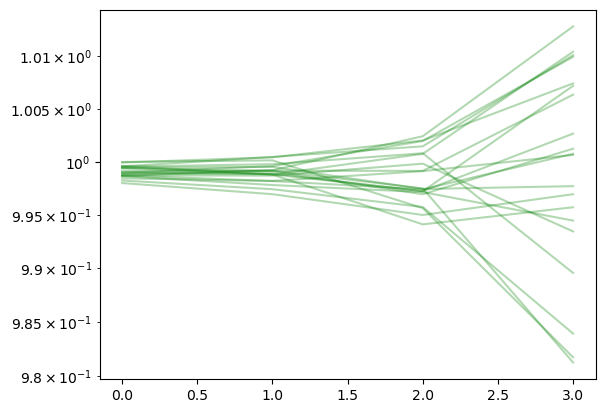

In [13]:
plt.figure()
for i in range(nb_sims):
    # plt.plot(s1_full_list[i, 0], label='Full', alpha=0.3, color='blue')
    # plt.plot(s1_halfs_list[i].mean(axis=0)[0], label='Mean from 8 halves', alpha=0.3, color='orange')
    plt.plot(s1_full_list[i, 0].squeeze().cpu() / s1_halfs_list[i].mean(axis=0)[0].squeeze().cpu(), label='Ratio', alpha=0.3, color='green')
#plt.legend()
plt.yscale('log')
plt.show()